In [48]:
import torch
print("Pytorch " + torch.__version__)
import pandas as pd
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import Trainer, TrainingArguments, EvalPrediction
from datasets import load_dataset

from sklearn import metrics
from scipy import stats
from functools import partial
from tqdm.auto import tqdm

from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Create device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

Pytorch 1.13.1


'cuda'

In [2]:
cas_voc = pd.read_csv("./cas_voc.tsv", sep="\t")
cas_voc.head(3)

,Loci_id,Strand,Genome_assembly,Chromosome,N1,Protein_id,B2,Gene_id,Gene_family,Type,Species,Start,End,Seq,Prot,Embs
0,RN99_05230,-,GCA_001296125.1,CP012714.1,991.0,ALF19893_1,+,cd09644,csn2,CAS-II-A,Fusobacterium_nucleatum_sub_vincentii_ChDC_F8_...,1100111,1100773,TTAGAAAATTTCACATAAATCATTATCTATAACAATTAAATTATCA...,MTFQYKGFNFKIDFEEKNIFSLIVENKRAYRKIIEDLVNNSNIEDG...,"5.101668462157249451e-02,4.367627203464508057e..."
1,RN99_05235,-,GCA_001296125.1,CP012714.1,992.0,ALF20727_1,+,mkCas0206,cas2,CAS-II-A,Fusobacterium_nucleatum_sub_vincentii_ChDC_F8_...,1100770,1101075,TCATAAAACCACAAGCCTTTCATCTGTTTCTAAAAATGTCCCTTTT...,MRMLLFFDLPSVTNSDLKEYRKFRKFLIENGFSMLQESVYSKLLLH...,"6.999336928129196167e-02,-9.389735758304595947..."
2,RN99_05240,-,GCA_001296125.1,CP012714.1,993.0,ALF19894_1,+,cd09720,cas1,CAS-II-A,Fusobacterium_nucleatum_sub_vincentii_ChDC_F8_...,1101080,1101958,CTATAACTCATCTTGAAAAAATCTCACTAATGATAAATCATTTGAG...,MSGWRVIIVTGRGKLDLRYNSISIRRDNGTDFIHIGEVNTLILETT...,"4.088897258043289185e-02,-6.158418953418731689..."


In [3]:
embs = cas_voc["Embs"]
labels = cas_voc["Gene_family"]
embs = [np.fromstring(row, sep=',') for row in embs]
embs = np.array(embs)
len(embs)

36970

In [15]:
# Making my own tokenizer because apparently TPOT forgot how to read string classes

path_classes = "./genes_to_use.tsv"
with open(path_classes) as file:
    lines = []
    for i, line in enumerate(file):
        if i!=0:
            line = line.rstrip('\n')
            parts = line.split('\t')
            lines.append(parts[0])
token = lines.index

tags = []
for label in labels:
    tags.append(token(label))
print(tags[0: 3])
print(labels[0: 3])


[14, 1, 0]
0    csn2
1    cas2
2    cas1
Name: Gene_family, dtype: object


In [16]:
X_train, X_test, y_train, y_test = train_test_split(embs, tags,
                                                    train_size=0.75, test_size=0.25, random_state=42, shuffle=True, stratify=tags)

In [6]:
# Configuration search, takes LONG (~3 hours)

tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                      config_dict='TPOT light', warm_start=False, use_dask=True, periodic_checkpoint_folder="./tpot_checkpoints/", scoring='balanced_accuracy', cv=10)
tpot.fit(X_train, y_train)
tpot.export('tpot_light.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]

In [19]:
# For TPOT-light scoring='balanced_accuracy', cv=10, generations=5, population_size=20,
# Best pipeline: LogisticRegression(RobustScaler(input_matrix), C=1.0, dual=False, penalty=l2)

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# Average CV score on the training set was: 0.9474667732147433
exported_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(C=1.0, dual=False, penalty="l2", max_iter=100)
)

exported_pipeline.fit(X_train, y_train)
exported_pipeline.score(X_test, y_test)



c:\Users\Dart_ilder\miniconda3\envs\.conda_Cas\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9800930433841826

In [72]:
# Checking accuracy of the least represented class

mask = (tags ==34)
tags = np.array(tags)
a = tags[mask]
A = np.array(embs)[mask]
exported_pipeline.score(A, a)

'csb1gr7'

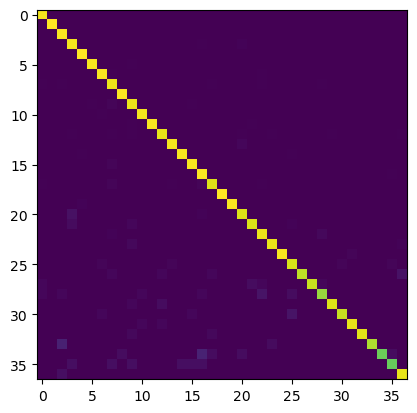

In [60]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
y_true = y_test
y_pred = exported_pipeline.predict(X_test)
cm = confusion_matrix(y_true, y_pred, normalize= "true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
plt.imshow(cm)

In [74]:
import joblib
joblib.dump(exported_pipeline, "tpot_pipline.sav")

['tpot_pipline.sav']